In [ ]:
#!pip install pytorch-crf
!pip install seqeval

In [2]:
import os, json, numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoConfig, AutoModel, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
from seqeval.metrics import classification_report
from torchcrf import CRF 
#from TorchCRF import CRF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
def parse_conll(path):
    tokens, labels = [], []
    with open(path, encoding="utf-8") as f:
        s_tok, s_lab = [], []
        for line in f:
            line = line.strip()
            if not line:
                if s_tok:
                    tokens.append(s_tok); labels.append(s_lab)
                    s_tok, s_lab = [], []
                continue
            parts = line.split("\t")
            if len(parts) >= 3:
                tok, _, ner = parts[0], parts[1], parts[2]
                s_tok.append(tok); s_lab.append(ner)
        if s_tok:
            tokens.append(s_tok); labels.append(s_lab)
    return tokens, labels

dataset_path = "/kaggle/input/myner-mmdt/"
train_tokens, train_labels = parse_conll(dataset_path + "ner_train.conll")
val_tokens,   val_labels = parse_conll(dataset_path + "ner_val.conll")
test_tokens,  test_labels  = parse_conll(dataset_path + "ner_test.conll")


print(len(train_tokens), len(val_tokens), len(test_tokens))

45894 11474 14343


In [4]:
# === 2) Build label vocab ===
all_labels = train_labels + val_labels  # build from train+val (test unseen)
uniq = sorted({t for seq in all_labels for t in seq})
if "O" not in uniq: uniq = ["O"] + [l for l in uniq if l != "O"]

label2id = {l:i for i,l in enumerate(uniq)}
id2label = {i:l for l,i in label2id.items()}
num_labels = len(label2id)
print("Labels:", label2id)


Labels: {'B-DATE': 0, 'B-LOC': 1, 'B-TIME': 2, 'I-DATE': 3, 'I-LOC': 4, 'I-TIME': 5, 'O': 6}


In [5]:
# === 3) Tokenizer (FAST) ===
model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

MAX_LEN = 128

def tokenize_and_align(tokens_list, labels_list):
    enc = tokenizer(
        tokens_list,
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_attention_mask=True
    )
    all_label_ids = []
    for i, labels in enumerate(labels_list):
        word_ids = enc.word_ids(batch_index=i)
        prev = None
        label_ids = []
        for w in word_ids:
            if w is None:
                label_ids.append(-100)  # special/padding
            elif w != prev:
                label_ids.append(label2id[labels[w]])      # first piece -> true label
            else:
                # subword -> give I- tag if B-*
                curr = labels[w]
                if curr.startswith("B-"):
                    curr = "I-" + curr[2:]
                label_ids.append(label2id.get(curr, label2id["O"]))
            prev = w
        all_label_ids.append(label_ids)
    enc["labels"] = all_label_ids
    return {k: torch.tensor(v) for k, v in enc.items()}

train_enc = tokenize_and_align(train_tokens, train_labels)
val_enc   = tokenize_and_align(val_tokens,   val_labels)
test_enc  = tokenize_and_align(test_tokens,  test_labels)


In [6]:
# === 4) PyTorch Datasets ===
class NERDataset(Dataset):
    def __init__(self, enc):
        self.enc = enc
    def __len__(self): return self.enc["input_ids"].shape[0]
    def __getitem__(self, idx):
        return {
            "input_ids": self.enc["input_ids"][idx],
            "attention_mask": self.enc["attention_mask"][idx],
            "labels": self.enc["labels"][idx]
        }

train_ds = NERDataset(train_enc)
val_ds   = NERDataset(val_enc)
test_ds  = NERDataset(test_enc)

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, DataLoader
from torch.optim import AdamW
from transformers import AutoModel, get_linear_schedule_with_warmup
import time

# -----------------------
# 1️⃣ Define DistilBERT + CRF model
# -----------------------
class DistilBertCRF(nn.Module):
    def __init__(self, model_name, num_labels, dropout=0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size, num_labels)  # emission scores
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs.last_hidden_state)  # (B, L, H)
        emissions = self.classifier(sequence_output)              # (B, L, num_labels)

        if labels is not None:
            # ✅ Create mask for valid tokens
            mask = labels.ne(-100)
            mask[:, 0] = True  # Ensure first timestep is always unmasked

            # ✅ Replace masked labels with a safe value (usually 'O' = 0)
            safe_labels = labels.clone()
            safe_labels[~mask] = 0
            safe_labels[:, 0] = safe_labels[:, 0].clamp(0, self.crf.num_tags-1)

            log_likelihood = self.crf(emissions, safe_labels, mask=mask, reduction='mean')
            return -log_likelihood
        else:
            mask = attention_mask.bool()
            mask[:, 0] = True  # first timestep must be on
            return self.crf.decode(emissions, mask=mask)  # Best label sequences


In [8]:
num_labels = len(label2id)  # same mapping used in training

model_name = "distilbert-base-multilingual-cased"

model = DistilBertCRF(model_name, num_labels)


2025-08-20 04:02:08.567773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755662528.586206     157 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755662528.591500     157 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:

checkpoint_path = "/kaggle/input/distilbert-crf/distilbert_crf_ner.pth"
state_dict = torch.load(checkpoint_path,  map_location=device,weights_only=True)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

DistilBertCRF(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

In [10]:
from seqeval.metrics import classification_report
import numpy as np

# Make sure model is in evaluation mode
print('device:')
print(device)
model.to(device)
model.eval()

true_labels_all = []
pred_labels_all = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Get predictions from CRF
        predictions = model(input_ids, attention_mask=attention_mask, labels=None)  # list of lists

        # Convert label ids to actual labels
        for i in range(len(labels)):
            true_seq = []
            pred_seq = []

            for j in range(labels[i].size(0)):
                if labels[i, j] == -100:
                    continue  # skip padding
                true_seq.append(id2label[labels[i, j].item()])
                pred_seq.append(id2label[predictions[i][j]])

            true_labels_all.append(true_seq)
            pred_labels_all.append(pred_seq)

# Print classification report
print(classification_report(true_labels_all, pred_labels_all))


device:
cuda
              precision    recall  f1-score   support

        DATE       0.92      0.94      0.93      2614
         LOC       0.84      0.86      0.85     10638
        TIME       0.87      0.90      0.88       557

   micro avg       0.86      0.88      0.87     13809
   macro avg       0.87      0.90      0.89     13809
weighted avg       0.86      0.88      0.87     13809



In [ ]:
from seqeval.metrics import f1_score

f1 = f1_score(true_labels_all,  pred_labels_all)
print(f"Entity-level F1: {f1:.4f}")

In [11]:
from sklearn.metrics import classification_report

# # Flatten sequences (BIO format preserved)
# y_true = [label for seq in all_true for label in seq]
# y_pred = [label for seq in all_pred for label in seq]

y_true = [label for seq in true_labels_all for label in seq]
y_pred = [label for seq in pred_labels_all for label in seq]

# Print classification report with BIO tags
print(classification_report(y_true, y_pred, digits=4, zero_division=0))

              precision    recall  f1-score   support

      B-DATE     0.9431    0.9602    0.9516      2538
       B-LOC     0.8913    0.9089    0.9000     10280
      B-TIME     0.9293    0.9546    0.9418       551
      I-DATE     0.9562    0.9664    0.9613     16296
       I-LOC     0.8902    0.9098    0.8999     59371
      I-TIME     0.9528    0.9804    0.9664      2758
           O     0.9942    0.9927    0.9934   1162839

    accuracy                         0.9876   1254633
   macro avg     0.9367    0.9533    0.9449   1254633
weighted avg     0.9877    0.9876    0.9877   1254633



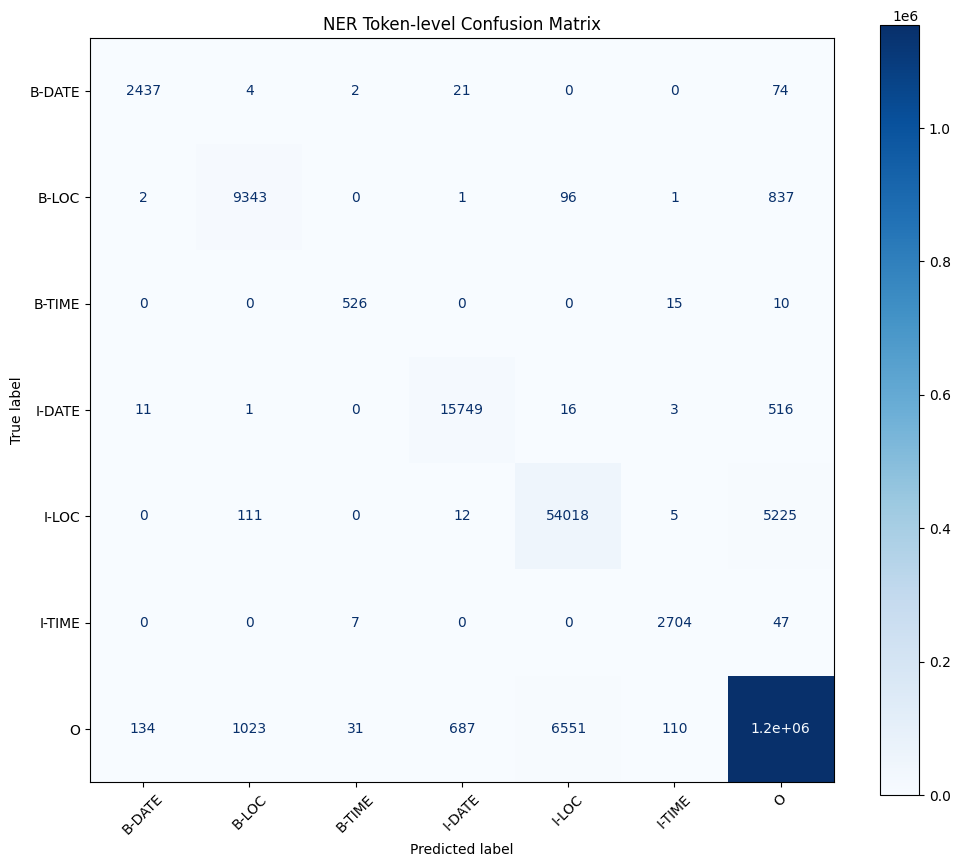

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Flatten predictions and true labels
true_flat = [label for seq in true_labels_all for label in seq]
pred_flat = [label for seq in pred_labels_all for label in seq]

# Get unique labels (make sure O is included)
labels_unique = sorted(list(set(true_flat) | set(pred_flat)))

# Compute confusion matrix
cm = confusion_matrix(true_flat, pred_flat, labels=labels_unique)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_unique)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("NER Token-level Confusion Matrix")
plt.show()


In [30]:
import random
import pandas as pd
import torch

def show_random_predictions(model, tokenizer, id2label, test_dataset, num_sentences=5, device="cuda"):
    """
    Show random sentences (that contain at least one entity),
    with tokens, true labels, and predicted labels in a table.
    
    test_dataset: dict with keys "tokens" and "labels", where labels are integer IDs
    id2label: dict mapping label IDs -> string labels
    """
    model.eval()
    random_sentences = []

    # keep only sentences with at least one non-O in gold labels
    valid_indices = [
        i for i, labels in enumerate(test_dataset["labels"])
        if any(id2label[l] != "O" for l in labels)
    ]

    chosen = random.sample(valid_indices, min(num_sentences, len(valid_indices)))

    for idx in chosen:
        tokens = test_dataset["tokens"][idx]        # original tokens
        true_ids = test_dataset["labels"][idx]      # gold label ids
        true_labels = [id2label[l] for l in true_ids]

        # encode tokens
        encoding = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", truncation=True)
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        # predict using CRF-based model (returns list of label IDs)
        with torch.no_grad():
            pred_ids = model(input_ids, attention_mask=attention_mask, labels=None)[0]

        pred_labels = [id2label[p] for p in pred_ids]

        # align lengths (skip special tokens)
        filtered_tokens, golds, preds = [], [], []
        word_ids = encoding.word_ids()  # map subwords to original tokens
        seen = set()
        for j, w_id in enumerate(word_ids):
            if w_id is None or w_id in seen:
                continue
            seen.add(w_id)
            filtered_tokens.append(tokens[w_id])
            golds.append(true_labels[w_id])
            preds.append(pred_labels[j])

        # store as dataframe
        df = pd.DataFrame({
            "Token": filtered_tokens,
            "True NER": golds,
            "Predicted NER": preds
        })
        random_sentences.append((tokens, df))

    return random_sentences


# 1. Parse CoNLL file
tokens, labels_str = parse_conll("/kaggle/input/myner-mmdt/ner_test.conll")

# 2. Convert string labels to IDs
label2id = {v: k for k, v in id2label.items()}
labels = [[label2id[l] for l in seq] for seq in labels_str]

# 3. Build dataset dictionary
test_dataset = {"tokens": tokens, "labels": labels}

# 4. Show random predictions
examples = show_random_predictions(model, tokenizer, id2label, test_dataset, num_sentences=7, device=device)

# # 5. Display nicely
# for tokens, df in examples:
#     print("\nSentence:", " ".join(tokens))
#     print(df.to_string(index=False))

from tabulate import tabulate

def print_predictions_simple(examples):
    print("\n=== Predicted Sentences ===")
    for i, (tokens, df) in enumerate(examples, 1):
        print(f"\nSentence {i}:")
        # Header
        print("Token\t\tTrue NER\tPredicted NER")
        print("-" * 50)
        
        for token, true_label, pred_label in zip(df['Token'], df['True NER'], df['Predicted NER']):
            print(f"{token}\t\t{true_label}\t\t{pred_label}")


print_predictions_simple(examples)



=== Predicted Sentences ===

Sentence 1:
Token		True NER	Predicted NER
--------------------------------------------------
မ		O		O
ငတ်		O		O
ရုံ		O		O
တ		O		O
မယ်		O		O
စားသောက်		O		O
နေ		O		O
ကြ		O		O
ရ		O		O
တာ		O		O
''		O		O
လို့		O		O
ရန်ကုန်		B-LOC		B-LOC
၊		O		O
ရွှေပြည်သာ		B-LOC		B-LOC
မြို့နယ်		I-LOC		I-LOC
က		O		O
အိမ်ရှင်		O		O
မ		O		O
တစ်		O		O
ဦး		O		O
က		O		O
ပြော		O		O
ပါ		O		O
တယ်		O		O
။		O		O

Sentence 2:
Token		True NER	Predicted NER
--------------------------------------------------
ရေ		O		O
လိုအပ်		O		O
သော		O		O
လူ		O		O
များ		O		O
သို့		O		O
ရေ		O		O
ရ		O		O
ရှိ		O		O
အောင်		O		O
လုပ်		O		O
ရန်		O		O
အခြေခံ		O		O
ကျ		O		O
သော		O		O
ဖွဲ့စည်း		O		O
တည်ဆောက်		O		O
မှု		O		O
မ		O		O
ရှိ		O		O
ခြင်း		O		O
ကြောင့်		O		O
အာဖရိက		B-LOC		B-LOC
တွင်		O		O
ရေ		O		O
ရှားပါး		O		O
မှု		O		O
ဖြစ်		O		O
စေ		O		O
ခဲ့		O		O
သည်		O		O
ဟု		O		O
ရ		O		O
စ်ဂျ်		O		O
ဘာ		O		O
မန်		O		O
က		O		O
ပြော		O		O
ခဲ့		O		O
သည်		O		O
။		O		O

Sentence 3:
Token		True NER	Predicted NER
----------

In [32]:
def predict_raw_clean(texts, model, tokenizer, id2label, device):
    model.eval()
    results = []

    for text in texts:
        encoding = tokenizer(text, return_tensors="pt", truncation=True)
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        with torch.no_grad():
            predictions = model(input_ids, attention_mask=attention_mask, labels=None)

        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
        pred_labels = [id2label[p] for p in predictions[0]]

        # Merge subword tokens (remove ##)
        clean_tokens, clean_labels = [], []
        current_word, current_label = "", None

        for tok, lab in zip(tokens, pred_labels):
            if tok in tokenizer.all_special_tokens:
                continue
            if tok.startswith("##"):
                current_word += tok[2:]
            else:
                if current_word:  # save previous
                    clean_tokens.append(current_word)
                    clean_labels.append(current_label)
                current_word = tok
                current_label = lab
        if current_word:
            clean_tokens.append(current_word)
            clean_labels.append(current_label)

        token_preds = list(zip(clean_tokens, clean_labels))
        results.append({"text": text, "predictions": token_preds})

    return results


# Example usage
texts = [
    "ပဲခူးတိုင်း၊ သဲကုန်းမြို့နယ်အတွင်း စစ်တပ်က စစ်ကြောင်းထိုးနေရာတွင် သဲကုန်းမြို့နယ်စီမံအုပ်ချုပ်ရေးအဖွဲ့ဝင် ၁ ဗိုလ်မှူး စံရွှေမြင့်က ဦးစီးပြီး ကျေးရွားများမှ ပြည်သူပိုင် ရွှေ၊ငွေ၊ ဆိုင်ကယ်၊ စက်ဘီးနှင့်ကားများကို လုယက်ကာ စစ်သားများ ခွဲဝေပေးနေကြောင်း သဲကုန်းမြို့အခြေစိုက် တော်လှန်ရေးသတင်းရင်းမြစ်နှင့် တပ်အသိုင်းအ၀ိုင်းထံမှ စုံစမ်းသိရှိရသည်။"
]

results = predict_raw_clean(texts, model, tokenizer, id2label, device)

for r in results:
    print(f"\nInput: {r['text']}\n")
    for tok, lab in r["predictions"]:
        print(f"{tok:15} -> {lab}")



Input: ပဲခူးတိုင်း၊ သဲကုန်းမြို့နယ်အတွင်း စစ်တပ်က စစ်ကြောင်းထိုးနေရာတွင် သဲကုန်းမြို့နယ်စီမံအုပ်ချုပ်ရေးအဖွဲ့ဝင် ၁ ဗိုလ်မှူး စံရွှေမြင့်က ဦးစီးပြီး ကျေးရွားများမှ ပြည်သူပိုင် ရွှေ၊ငွေ၊ ဆိုင်ကယ်၊ စက်ဘီးနှင့်ကားများကို လုယက်ကာ စစ်သားများ ခွဲဝေပေးနေကြောင်း သဲကုန်းမြို့အခြေစိုက် တော်လှန်ရေးသတင်းရင်းမြစ်နှင့် တပ်အသိုင်းအ၀ိုင်းထံမှ စုံစမ်းသိရှိရသည်။

ပဲခူးတိုင်း     -> B-LOC
၊               -> O
သဲကုန်းမြို့နယ်အတွင်း -> B-LOC
စစ်တပ်က         -> O
စစ်ကြောင်းထိုးနေရာတွင် -> O
သဲကုန်းမြို့နယ်စီမံအုပ်ချုပ်ရေးအဖွဲ့ဝင် -> O
၁               -> O
ဗိုလ်မှူး       -> O
စံရွှေမြင့်က    -> O
ဦးစီးပြီး       -> O
ကျေးရွားများမှ  -> O
ပြည်သူပိုင်     -> O
ရွှေ            -> O
၊               -> O
ငွေ             -> O
၊               -> O
ဆိုင်ကယ်        -> O
၊               -> O
စက်ဘီးနှင့်ကားများကို -> O
လုယက်ကာ         -> O
စစ်သားများ      -> O
ခွဲဝေပေးနေကြောင်း -> O
သဲကုန်းမြို့အခြေစိုက် -> O
တော်လှန်ရေးသတင်းရင်းမြစ်နှင့် -> O
တပ်အသိုင်းအ၀ိုင်းထံမှ -> O
စုံစမ်းသိရှိရသည် -> O
။               -> O
